In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
file_path = "/content/drive/MyDrive/ML Collab/Production/Solar Power Plant Data.csv"
dtypes = {
  'Date-Hour': str,
  'WindSpeed': float,
  'Sunshine': float,
  'AirPressure': float,
  'Radiation': float,
  'AirTemperature': float,
  'RelativeAirHumidity': float,
  'SystemProduction': float,
}

try:
  df = pd.read_csv(file_path, sep=',', dtype=dtypes, na_values=['nan','?'])
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the file path.")
  df = None

df = df.rename(columns={'Date-Hour(NMT)': 'Date-Time'})


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date-Time            8760 non-null   object 
 1   WindSpeed            8760 non-null   float64
 2   Sunshine             8760 non-null   float64
 3   AirPressure          8760 non-null   float64
 4   Radiation            8760 non-null   float64
 5   AirTemperature       8760 non-null   float64
 6   RelativeAirHumidity  8760 non-null   float64
 7   SystemProduction     8760 non-null   float64
dtypes: float64(7), object(1)
memory usage: 547.6+ KB


,Date-Time,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.6,0.0,1003.8,-7.4,0.1,97.0,0.0
1,01.01.2017-01:00,1.7,0.0,1003.5,-7.4,-0.2,98.0,0.0
2,01.01.2017-02:00,0.6,0.0,1003.4,-6.7,-1.2,99.0,0.0
3,01.01.2017-03:00,2.4,0.0,1003.3,-7.2,-1.3,99.0,0.0
4,01.01.2017-04:00,4.0,0.0,1003.1,-6.3,3.6,67.0,0.0


In [84]:
if df is not None:
  df['Date-Time'] = pd.to_datetime(df['Date-Time'], format='%d.%m.%Y-%H:%M')
  df['Day'] = df['Date-Time'].dt.day
  df['Month'] = df['Date-Time'].dt.month
  df['Hour'] = df['Date-Time'].dt.hour


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date-Time            8760 non-null   datetime64[ns]
 1   WindSpeed            8760 non-null   float64       
 2   Sunshine             8760 non-null   float64       
 3   AirPressure          8760 non-null   float64       
 4   Radiation            8760 non-null   float64       
 5   AirTemperature       8760 non-null   float64       
 6   RelativeAirHumidity  8760 non-null   float64       
 7   SystemProduction     8760 non-null   float64       
 8   Day                  8760 non-null   int32         
 9   Month                8760 non-null   int32         
 10  Hour                 8760 non-null   int32         
dtypes: datetime64[ns](1), float64(7), int32(3)
memory usage: 650.3 KB


,Date-Time,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,Day,Month,Hour
0,2017-01-01 00:00:00,0.6,0.0,1003.8,-7.4,0.1,97.0,0.0,1,1,0
1,2017-01-01 01:00:00,1.7,0.0,1003.5,-7.4,-0.2,98.0,0.0,1,1,1
2,2017-01-01 02:00:00,0.6,0.0,1003.4,-6.7,-1.2,99.0,0.0,1,1,2
3,2017-01-01 03:00:00,2.4,0.0,1003.3,-7.2,-1.3,99.0,0.0,1,1,3
4,2017-01-01 04:00:00,4.0,0.0,1003.1,-6.3,3.6,67.0,0.0,1,1,4


In [85]:
if df is not None:
  cols_to_move = ['Day', 'Month', 'Hour']
  new_columns = cols_to_move + [col for col in df.columns if col not in cols_to_move and col != 'Date-Time']
  df = df[new_columns]
df.head()

,Day,Month,Hour,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,1,1,0,0.6,0.0,1003.8,-7.4,0.1,97.0,0.0
1,1,1,1,1.7,0.0,1003.5,-7.4,-0.2,98.0,0.0
2,1,1,2,0.6,0.0,1003.4,-6.7,-1.2,99.0,0.0
3,1,1,3,2.4,0.0,1003.3,-7.2,-1.3,99.0,0.0
4,1,1,4,4.0,0.0,1003.1,-6.3,3.6,67.0,0.0


In [86]:
if df is not None:
  max_production = df['SystemProduction'].max()
  df['SystemProduction'] = df['SystemProduction'] / max_production

df

,Day,Month,Hour,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,1,1,0,0.6,0.0,1003.8,-7.4,0.1,97.0,0.0
1,1,1,1,1.7,0.0,1003.5,-7.4,-0.2,98.0,0.0
2,1,1,2,0.6,0.0,1003.4,-6.7,-1.2,99.0,0.0
3,1,1,3,2.4,0.0,1003.3,-7.2,-1.3,99.0,0.0
4,1,1,4,4.0,0.0,1003.1,-6.3,3.6,67.0,0.0
...,...,...,...,...,...,...,...,...,...,...
8755,31,12,19,4.1,0.0,988.2,-4.8,-0.7,94.0,0.0
8756,31,12,20,2.1,0.0,987.3,-5.0,-0.3,95.0,0.0
8757,31,12,21,1.8,0.0,986.7,-5.3,0.2,93.0,0.0
8758,31,12,22,2.2,0.0,986.0,-5.4,0.3,92.0,0.0


In [87]:
needs_scaling = [ 'WindSpeed', 'Sunshine', 'AirPressure', 'Radiation', 'AirTemperature', 'RelativeAirHumidity']
scaler = MinMaxScaler()
df[needs_scaling] = scaler.fit_transform(df[needs_scaling])
df.head()

,Day,Month,Hour,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,1,1,0,0.055046,0.0,0.465602,0.00209,0.316456,0.965517,0.0
1,1,1,1,0.155963,0.0,0.461916,0.00209,0.308861,0.977011,0.0
2,1,1,2,0.055046,0.0,0.460688,0.00286,0.283544,0.988506,0.0
3,1,1,3,0.220183,0.0,0.459459,0.00231,0.281013,0.988506,0.0
4,1,1,4,0.366972,0.0,0.457002,0.00330,0.405063,0.620690,0.0


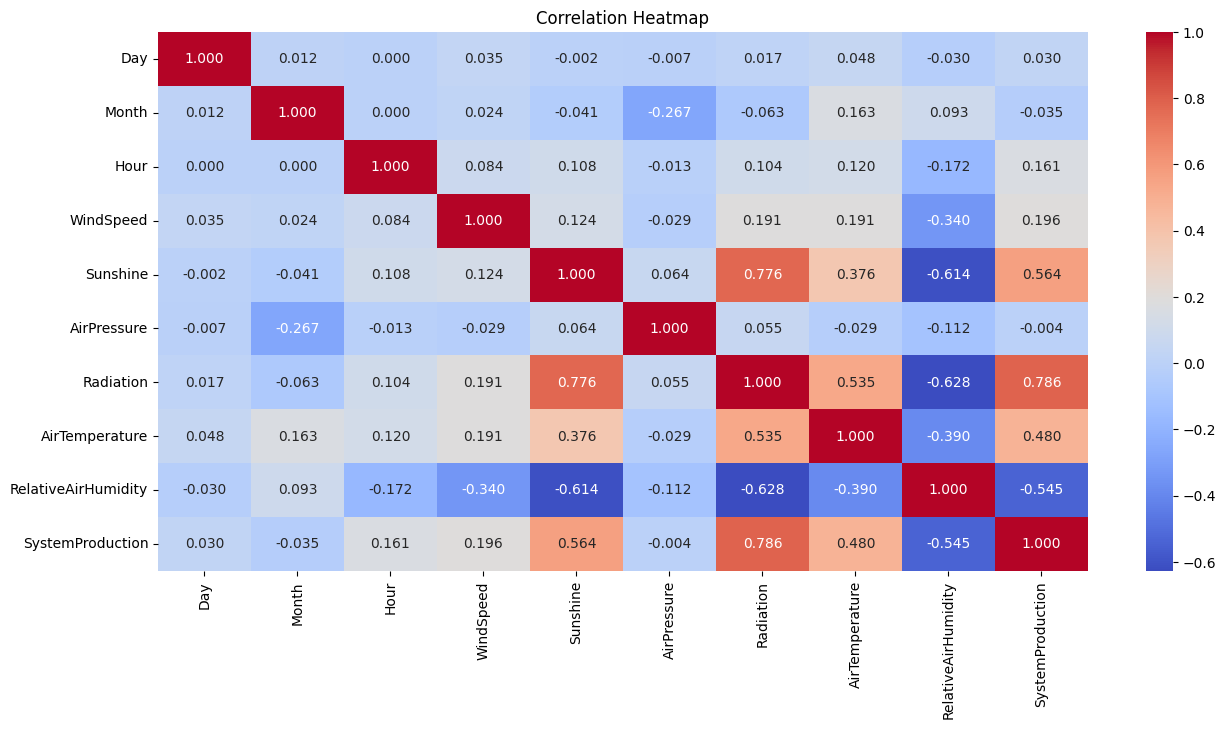

In [88]:
corr_mat=df.corr()
plt.figure(figsize=(15,7))
sns.heatmap(corr_mat, annot=True, fmt=".3f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [89]:
###########################################
# Saving the processed dataset #
###########################################

import os
import joblib

drive_save_dir = '/content/drive/MyDrive/ML Collab/Production/'

os.makedirs(drive_save_dir, exist_ok=True)

# Save the scaler
scaler_path = os.path.join(drive_save_dir, 'production_scaler.pkl')
joblib.dump(scaler, scaler_path)

# Save the DataFrame
df_path = os.path.join(drive_save_dir, 'production_dataset.csv')
df.to_csv(df_path)

print(f"DataFrame saved to: {df_path}")



DataFrame saved to: /content/drive/MyDrive/ML Collab/Production/production_dataset.csv
